In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import math
import networkx as nx

### Import data

In [2]:
orphans = pd.read_csv(r'E_WEB LIST OF ORPHANS _12 DELIN 03.31.2020.csv')
data = gpd.read_file(r'Wells\well013\well013b.shp')
basemap = gpd.read_file(r'Maps\Basemap013\road013l.shp')

### Define distance calculator

In [3]:
R_EARTH = 3958.8  #miles

# Use formula: angle (radians) * R_EARTH
def angleToDist(x, y): # Input: tuples x and y (lat. and long.)
    a = math.sqrt( (y[0]-x[0])**2 + (y[1]-x[1])**2 )
    return R_EARTH * (math.pi/180) * a

### Combining well datasets

In [4]:
ata_orp = orphans.query('COUNTY_NAME == "ATASCOSA"')

wellid = []
for i in ata_orp.index.values:
    wellid.append(str(ata_orp.API[i])[-5:])
    
ata_orp['WELLID'] = wellid

spatial = data.merge(ata_orp, how='right', on='WELLID')

C:\Users\jcbre\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Removes wells with invalid coordinates (NaN):

In [5]:
spatial # notice index==1 has mostly NaN values - if a datapoint has no coordinates, then we can't really work with it

,BOTTOM_ID,SURFACE_ID,SYMNUM,APINUM,RELIAB,API10,API_x,LONG27,LAT27,LONG83,...,COUNTY_NAME,FIELD_NAME,OPERATOR_NAME,OPERATOR_NO,LEASE_NAME,OG_CODE,LEASE_ID,WELL_NO,API_y,WB_Months_Inactive
0,232827.0,232827.0,5.0,4201300361,15,01300361,01300361,-98.728977,29.050913,-98.729306,...,ATASCOSA,"ANCHORAGE, SOUTH","HAILEY, E. M.",342800,"FOWLER, SAN J.",G,2,1,1300361,279
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ATASCOSA,"IMOGENE, S. (CARRIZO)","TRAVELERS OIL & GAS, INC.",865970,"RICHTER, KATE",O,700,1,1301223,279
2,240419.0,240419.0,4.0,4201300098,15,01300098,01300098,-98.791863,29.000151,-98.792166,...,ATASCOSA,KYOTE,TOMAHAWK PETROLEUM,861695,"ROGERS, THEO. -A-",O,803,4,1300098,279
3,239761.0,239761.0,4.0,4201302970,15,01302970,01302970,-98.790920,29.005334,-98.791223,...,ATASCOSA,KYOTE,TOMAHAWK PETROLEUM,861695,"ROGERS, THEO. -A-",O,803,12,1302970,279
4,138728.0,138728.0,7.0,4201300840,15,01300840,01300840,-98.281008,28.889770,-98.281297,...,ATASCOSA,MUIL (QUEEN CITY SAND),JJRS INVESTMENTS INC.,427648,"MUIL, CHAS.",O,1280,2,1300840,229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1230036.0,1230036.0,4.0,4201334395,40,01334395,01334395,-98.345630,28.919651,-98.345920,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBER/ FALCON LEAL,O,17865,1,1334395,87
84,1236879.0,1236879.0,4.0,4201334437,55,01334437,01334437,-98.344300,28.917458,-98.344590,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBUR/FALCON BURGER,O,17928,2,1334437,87
85,1240269.0,1240269.0,4.0,4201334449,55,01334449,01334449,-98.338636,28.922762,-98.338926,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBUR/FALCON BURGER,O,17928,4,1334449,72
86,241217.0,241217.0,5.0,4201333889,40,01333889,01333889,-98.796631,29.186115,-98.796934,...,ATASCOSA,"BENTON CITY S, (ANACACHO)","REGENCY ENERGY, INC.",698761,"NAEGLIN, MIKE",G,227894,1,1333889,145


In [6]:
spatial_valid = spatial[spatial['LONG83']<-90]
spatial_valid

,BOTTOM_ID,SURFACE_ID,SYMNUM,APINUM,RELIAB,API10,API_x,LONG27,LAT27,LONG83,...,COUNTY_NAME,FIELD_NAME,OPERATOR_NAME,OPERATOR_NO,LEASE_NAME,OG_CODE,LEASE_ID,WELL_NO,API_y,WB_Months_Inactive
0,232827.0,232827.0,5.0,4201300361,15,01300361,01300361,-98.728977,29.050913,-98.729306,...,ATASCOSA,"ANCHORAGE, SOUTH","HAILEY, E. M.",342800,"FOWLER, SAN J.",G,2,1,1300361,279
2,240419.0,240419.0,4.0,4201300098,15,01300098,01300098,-98.791863,29.000151,-98.792166,...,ATASCOSA,KYOTE,TOMAHAWK PETROLEUM,861695,"ROGERS, THEO. -A-",O,803,4,1300098,279
3,239761.0,239761.0,4.0,4201302970,15,01302970,01302970,-98.790920,29.005334,-98.791223,...,ATASCOSA,KYOTE,TOMAHAWK PETROLEUM,861695,"ROGERS, THEO. -A-",O,803,12,1302970,279
4,138728.0,138728.0,7.0,4201300840,15,01300840,01300840,-98.281008,28.889770,-98.281297,...,ATASCOSA,MUIL (QUEEN CITY SAND),JJRS INVESTMENTS INC.,427648,"MUIL, CHAS.",O,1280,2,1300840,229
5,234904.0,234904.0,7.0,4201380288,45,01380288,01380288,-98.719805,29.180124,-98.720105,...,ATASCOSA,SOMERSET,"GREAT PLAINS RESOURCES, INC.",328746,"MILLER, M.",O,1636,3,1380288,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1230036.0,1230036.0,4.0,4201334395,40,01334395,01334395,-98.345630,28.919651,-98.345920,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBER/ FALCON LEAL,O,17865,1,1334395,87
84,1236879.0,1236879.0,4.0,4201334437,55,01334437,01334437,-98.344300,28.917458,-98.344590,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBUR/FALCON BURGER,O,17928,2,1334437,87
85,1240269.0,1240269.0,4.0,4201334449,55,01334449,01334449,-98.338636,28.922762,-98.338926,...,ATASCOSA,PLEASANTON (EDWARDS LIME),"EXCALIBUR E & P, LLC",256842,EXCALIBUR/FALCON BURGER,O,17928,4,1334449,72
86,241217.0,241217.0,5.0,4201333889,40,01333889,01333889,-98.796631,29.186115,-98.796934,...,ATASCOSA,"BENTON CITY S, (ANACACHO)","REGENCY ENERGY, INC.",698761,"NAEGLIN, MIKE",G,227894,1,1333889,145


Text(101.625, 0.5, 'latitude')

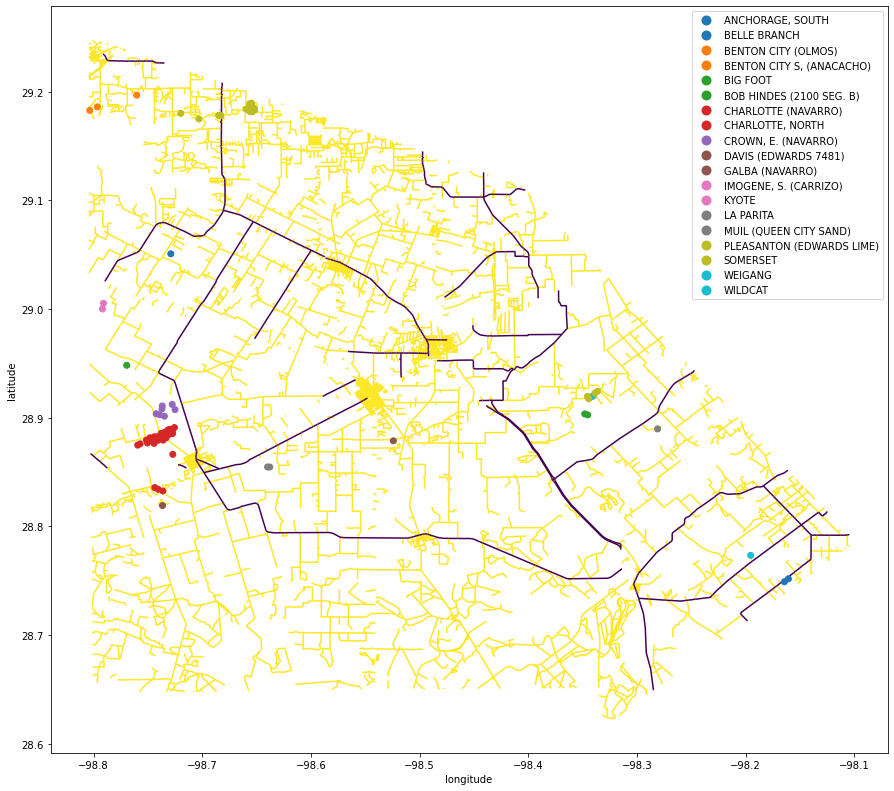

In [7]:
ax = basemap.plot(column='DISP_CODE', figsize=(15,15), zorder=0)
spatial.plot(column='FIELD_NAME', legend=True, ax=ax, zorder=1)

plt.xlabel('longitude')
plt.ylabel('latitude')

### Cluster wells into groups

In [8]:
CLUSTER_RADIUS = 1 #mile
clusters = [] # List of dataframes - each one containing a cluster of wells within ~ a [CLUSTER_RADIUS] mile radius

for i in spatial_valid.index:
    well = spatial_valid[spatial_valid.index==i]
    coordinates = (well['LONG83'].mean(), well['LAT83'].mean())
    findsCluster = False
    
    for j, C in enumerate(clusters):
        if angleToDist(coordinates, ( C['LONG83'].mean(), C['LAT83'].mean() ) ) < CLUSTER_RADIUS:
            temp = clusters[j].append(well) # if the well is close enough to a cluster, append it to the cluster dataframe
            clusters[j] = temp
            findsCluster = True
            break
        
    if not findsCluster: # otherwise create a new dataframe in the list
        clusters.append(well)
        
cluster_centers = [( C['LONG83'].mean(), C['LAT83'].mean() ) for C in clusters] # list of the centers of corresponding clusters

In [9]:
len(clusters)

22

Text(101.625, 0.5, 'latitude')

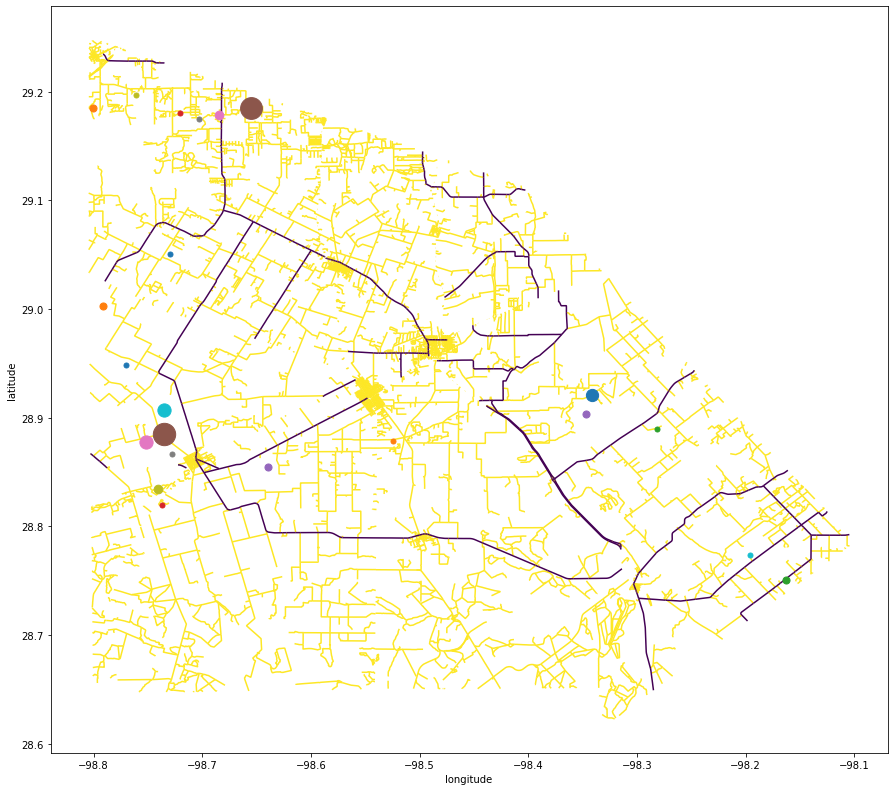

In [10]:
# Plot the clusters - the bigger the size, the greater the cluster
ax = basemap.plot(column='DISP_CODE', figsize=(15,15), zorder=0)
for i, C in enumerate(cluster_centers):
    plt.scatter(C[0], C[1], s=25*len(clusters[i]))

plt.xlabel('longitude')
plt.ylabel('latitude')

### Translate shapefile into Networkx Digraph

In [11]:
roads = nx.read_shp(r'Maps\Basemap013\road013l.shp')

for e in roads.edges.data():
    roads[e[0]][e[1]]['Distance'] = angleToDist(e[0], e[1])
    
    if (e[1], e[0]) not in roads.edges: # checks for duplicates
        roads.add_edge(e[1], e[0]) # adds inverse edge
        
        for A in e[2]:
            roads[e[1]][e[0]][A] = e[2][A]

In [12]:
nx.number_strongly_connected_components(roads)

187

Notice that there are many separate components, which separate the clusters. In Atascosa, there's one central connection and several small connections, often just two nodes. The following cells connect these small components to the main one.

In [13]:
strong_components = [c for c in sorted(nx.strongly_connected_components(roads), key=len, reverse=True)]
centers = [(sum(x[0] for x in c)/len(c), sum(x[1] for x in c)/len(c)) for c in strong_components]

In [14]:
def sq_dist(X, Y): # finds the squared euclidian distance between two tuples
    return (X[0]-Y[0])**2 + (X[1]-Y[1])**2


connected_roads = roads.copy()
conn_X, conn_Y = [], []

for c in strong_components[1:]:
    center = (sum(x[0] for x in c)/len(c), sum(x[1] for x in c)/len(c)) # finds center of the component
    
    main_node = (0,0) # finds closest point of main component to other
    for x in strong_components[0]:
        if sq_dist(x, center) < sq_dist(main_node, center):
            main_node = x
            
    side_node = (0,0) # finds closest point of other component to the previous point
    for x in c:
        if sq_dist(x, main_node) < sq_dist(side_node, main_node):
            side_node = x
            
    connected_roads.add_edge(main_node, side_node, Distance = angleToDist(main_node, side_node) )
    connected_roads.add_edge(side_node, main_node, Distance = angleToDist(main_node, side_node) )
    conn_X.append([main_node[0], side_node[0]]) # used for displaying added roads
    conn_Y.append([main_node[1], side_node[1]])

In [15]:
nx.number_strongly_connected_components(connected_roads)

1

Now that everything's connected, we'll be able to travel to every well. Below is a visualization of the added edges.

Text(101.625, 0.5, 'latitude')

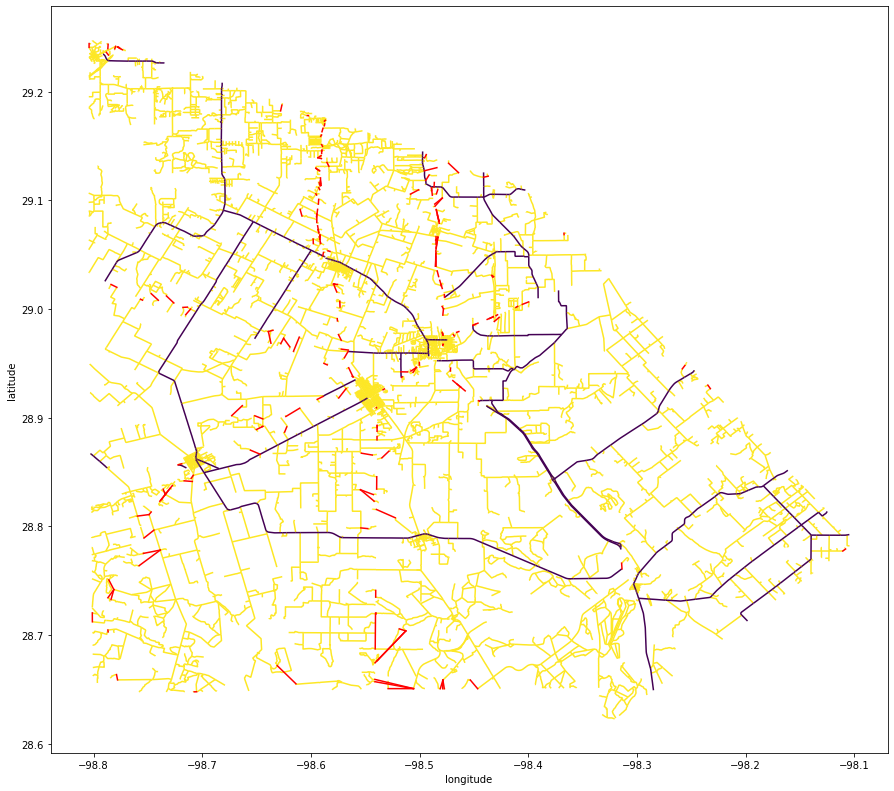

In [16]:
ax = basemap.plot(column='DISP_CODE', figsize=(15,15), zorder=0)

for i in range(len(conn_X)):
    plt.plot(conn_X[i], conn_Y[i], color='r')

plt.xlabel('longitude')
plt.ylabel('latitude')

### Add clusters to Digraph as nodes with an edge connected to the closest node already in the graph:

In [17]:
for C in cluster_centers:
    coords = (C[0], C[1])
    
    closest = (0,0)
    for node in connected_roads.nodes:
        if angleToDist(coords, node) < angleToDist(coords, closest):
            closest = node
            
    connected_roads.add_node(coords, well=True) #, {'Cluster': C, 'Size': len(C)})
            
    d = angleToDist(coords, closest)
    connected_roads.add_edge(coords, closest, Distance = d)
    connected_roads.add_edge(closest, coords, Distance = d)

In [18]:
reachable = []

for i in range(len(clusters)):
    for j in range(i+1, len(clusters)):
        p1 = cluster_centers[i]
        p2 = cluster_centers[j]
        reachable.append((i, j, nx.has_path(connected_roads, p1, p2)))
        
len(reachable), sum(int(x[2]) for x in reachable)

(231, 231)

## Reinforced Learner

For our learner algorithm, I've decided to use a Deep Q Learning (DQL) network, in order to help generalize each state. The main idea came from this link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
<br>MLP Code: https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [19]:
import random
import torch
import torch.nn as nn

OUTPUT_SIZE = len(clusters)

class DQN(nn.Module):
        def __init__(self, input_size, hidden_size):
            super(DQN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, OUTPUT_SIZE)
            self.sigmoid = torch.nn.Sigmoid()
            
            self.iter = 0
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

State's will be comprised of: (0: Position [index], 1: Available actions, 2: Distance already traveled)

In [20]:
def extract_features(state):
    NUM_FEATURES = OUTPUT_SIZE
    
    x = [0 for _ in range(NUM_FEATURES)]
    
    for i in range(OUTPUT_SIZE):
        if i in state[1]:
            x[i] = total_distance(state[0], i)
    
    return torch.FloatTensor(x)

In [21]:
DISCOUNT = 1
EPSILON_START = 2 # divide by sqrt(iter)

policy_net = DQN(OUTPUT_SIZE, OUTPUT_SIZE)

def select_action(state, opt=False): # epsilon greedy - opt: no exploration
    policy_net.iter += 1
    
    if random.random() > EPSILON_START/math.sqrt(policy_net.iter) and not opt:
        output = policy_net.forward(extract_features(state))
        valid_options = torch.FloatTensor([output[i] for i in state[1]])
        return state[1].pop( torch.argmax(valid_options) )
    else:
        return state[1].pop(random.randint(0, len(state[1])-1))

It'll be helpful to define a function to find the distance between clusters:

In [22]:
def total_distance(i, j): # Takes in indices of clusters and returns the total distance
    distance = 0
    path = nx.shortest_path(connected_roads, cluster_centers[i], cluster_centers[j])

    for k in range(1, len(path)): # Identifies the edge, stores the distance and adds it to the total distance
        distance += connected_roads.edges[path[k-1], path[k]]['Distance']
    return distance

In [23]:
def incorporate_feedback(state, action, reward, newState):
    x = extract_features(state)
    Q = policy_net.forward(x)
    
    '''V = -9999
    for a in state[1]:
        newActions = state[1].copy()
        newActions.remove(a)
        
        #tempState = extract_features((newState[0], newActions, newState[2]), a)
        #tempScore = policy_net.forward(tempState)
        tempScore = policy_net.forward(newState, a)
        if tempScore > V:
            V = tempScore'''
    
    criterion = nn.MSELoss()
    
    if newState==None:
        loss = criterion(Q, reward*torch.ones(OUTPUT_SIZE))
        
        optimizer = torch.optim.SGD(policy_net.parameters(), lr = 0.01)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return
    
    V = torch.max(policy_net.forward(extract_features(newState)))
    
    loss = criterion(Q, reward + DISCOUNT * V)

    # Optimize the model
    optimizer = torch.optim.SGD(policy_net.parameters(), lr = 0.01)
    optimizer.zero_grad()
    loss.backward()
    #for param in policy_net.parameters():
        #param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [24]:
START_NODE = 0 # index if starting cluster
DISTANCES = []
steps_done = 0

num_episodes = 100
for i in range(num_episodes):
    print("Episode #", i)
    # First restart the 'game'
    actions = [i for i in range(len(clusters))] # Actions are the indices of clusters <- remove once visited
    actions.remove(START_NODE)
    state = (START_NODE, actions, 0)
    
    traveled_distance = 0
    
    while state!=None:
        action = select_action(state)
        reward = -total_distance(state[0], action) # this is so that smaller distances have higher rewards
        
        #newActions = state[1].copy()
        #newActions.remove(action)
        newState = (action, state[1], state[2]-reward)
        if len(state[1])==0:
            newState = None
            
        incorporate_feedback(state, action, reward, newState)
        traveled_distance -= reward
        
        state = newState
        
    DISTANCES.append(traveled_distance)
    
DISTANCES

Episode # 0


C:\Users\jcbre\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([22])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode # 1
Episode # 2
Episode # 3
Episode # 4
Episode # 5
Episode # 6
Episode # 7
Episode # 8
Episode # 9
Episode # 10
Episode # 11
Episode # 12
Episode # 13
Episode # 14
Episode # 15
Episode # 16
Episode # 17
Episode # 18
Episode # 19
Episode # 20
Episode # 21
Episode # 22
Episode # 23
Episode # 24
Episode # 25
Episode # 26
Episode # 27
Episode # 28
Episode # 29
Episode # 30
Episode # 31
Episode # 32
Episode # 33
Episode # 34
Episode # 35
Episode # 36
Episode # 37
Episode # 38
Episode # 39
Episode # 40
Episode # 41
Episode # 42
Episode # 43
Episode # 44
Episode # 45
Episode # 46
Episode # 47
Episode # 48
Episode # 49
Episode # 50
Episode # 51
Episode # 52
Episode # 53
Episode # 54
Episode # 55
Episode # 56
Episode # 57
Episode # 58
Episode # 59
Episode # 60
Episode # 61
Episode # 62
Episode # 63
Episode # 64
Episode # 65
Episode # 66
Episode # 67
Episode # 68
Episode # 69
Episode # 70
Episode # 71
Episode # 72
Episode # 73
Episode # 74
Episode # 75
Episode # 76
Episode # 77
Episode 

[710.7122350074077,
 827.3757275687594,
 734.9401983004987,
 682.9822369781847,
 810.5541196787957,
 824.2734698303104,
 881.4757186441731,
 810.3669381438079,
 733.6745389787895,
 719.2793213422112,
 868.9433225771205,
 725.7580947312425,
 639.2728004493538,
 835.906441696407,
 751.2620304528195,
 802.0225328801564,
 916.4431124620207,
 777.6520227484921,
 887.0020241028915,
 766.7368550309208,
 766.7368550309209,
 806.2207217344632,
 766.736855030921,
 730.4092486758551,
 760.8056709546228,
 809.7080910065652,
 777.390022373277,
 724.5414081468342,
 788.9358355070681,
 796.4149793621112,
 775.2608570588587,
 796.9278959854494,
 883.6447633660448,
 812.6008498906451,
 792.193638979455,
 815.1471037816846,
 806.7790942765369,
 830.088131970489,
 747.5470862698423,
 688.1321196487694,
 640.66509327259,
 735.9937736580267,
 640.66509327259,
 623.0583541584557,
 786.3069883304875,
 650.095051567896,
 640.66509327259,
 708.5324069111429,
 720.1300160275425,
 640.66509327259,
 810.560172447

In [25]:
min(DISTANCES)

622.5847697745257

In [26]:
actions = [i for i in range(len(clusters))] # Actions are the indices of clusters <- remove once visited
actions.remove(START_NODE)
test_state = (START_NODE, actions, 0)

actions = [0]
while test_state!=None:
    action = select_action(test_state, opt=True)
    reward = -total_distance(test_state[0], action) # this is so that smaller distances have higher rewards
        
    newState = (action, test_state[1], test_state[2]-reward)
    if len(test_state[1])==0:
        newState = None
            
    #incorporate_feedback(state, action, reward, newState)
    traveled_distance -= reward
        
    test_state = newState
    actions.append(action)
actions

[0, 3, 16, 6, 9, 2, 10, 12, 18, 11, 17, 14, 5, 15, 13, 4, 21, 1, 8, 19, 20, 7]

Let's visualize the pathing the network takes on the map.

In [27]:
directions_x = [[] for _ in range(len(actions)-1)]
directions_y = [[] for _ in range(len(actions)-1)]

for i in range(1, len(actions)):
    p1, p2 = cluster_centers[actions[i-1]], cluster_centers[actions[i]]
    temp = nx.shortest_path(connected_roads, p1, p2, weight='Distance')
    for x in temp:
        directions_x[i-1].append(x[0])
        directions_y[i-1].append(x[1])

directions_x, directions_y

([[-98.72930564,
   -98.73675151020387,
   -98.72631528175722,
   -98.72611689802132,
   -98.72457566431257,
   -98.72060085785087,
   -98.70994323222094,
   -98.70827224016186,
   -98.70111623535608,
   -98.69890377038665,
   -98.69222006557958,
   -98.68858878636613,
   -98.68333985162967,
   -98.68066949903631,
   -98.68055530510932,
   -98.67915187111062,
   -98.67910559221573,
   -98.67908262912182,
   -98.67906812925352,
   -98.67905260820795,
   -98.67917477439511,
   -98.67921282831888,
   -98.67928877757718,
   -98.67932693626031,
   -98.67963232989408,
   -98.68199702169504,
   -98.68201286910958,
   -98.68213475915091,
   -98.68220347362104,
   -98.68233282057923,
   -98.68236331916003,
   -98.68241693696751,
   -98.6824548925536,
   -98.68245493986721,
   -98.68243972258672,
   -98.68247777143392,
   -98.68238692562724,
   -98.68903937198985,
   -98.69395217329898,
   -98.695493571977,
   -98.70033028152449,
   -98.72440075476565,
   -98.7273758869312,
   -98.72749821971809

Text(101.625, 0.5, 'latitude')

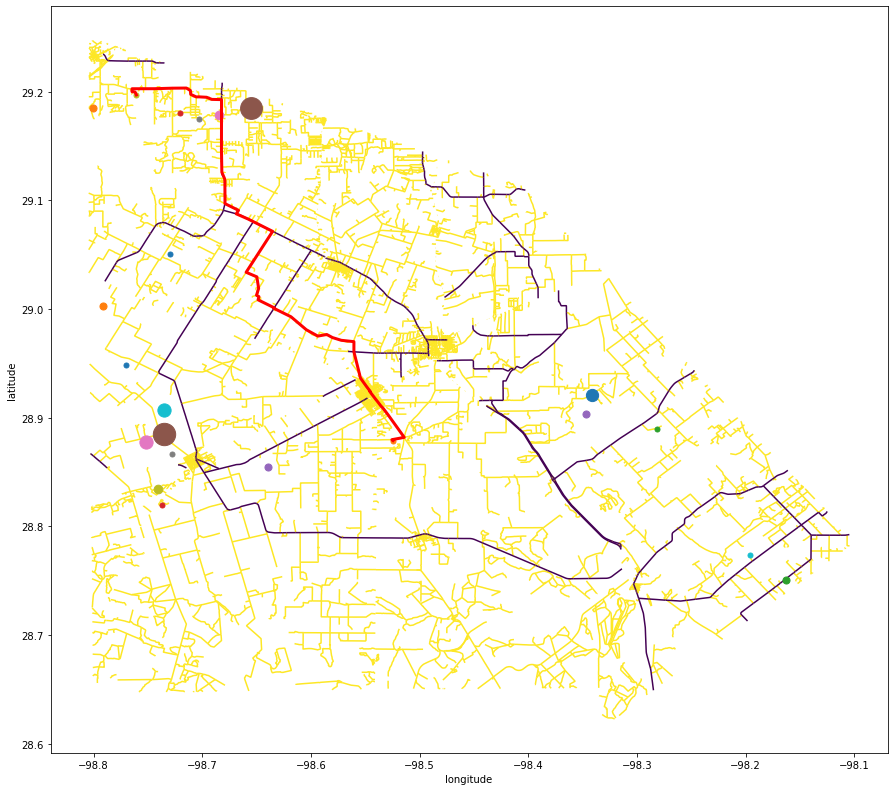

In [39]:
ax = basemap.plot(column='DISP_CODE', figsize=(15,15), zorder=0)
for i, C in enumerate(cluster_centers):
    plt.scatter(C[0], C[1], s=25*len(clusters[i]))

#plt.scatter(cluster_centers[0][0], cluster_centers[0][1], s=800)

path_num = 8
plt.plot(directions_x[path_num], directions_y[path_num], color='r', linewidth=3, animated=True)
#plt.plot(directions_x[1], directions_y[1], color='r', linewidth=7.5, animated=True)
#plt.plot(directions_x[2], directions_y[2], color='r', linewidth=7, animated=True)
#plt.plot(directions_x[3], directions_y[3], color='r', linewidth=6.5, animated=True)
#plt.plot(directions_x[4], directions_y[4], color='r', linewidth=6, animated=True)
#plt.plot(directions_x[5], directions_y[5], color='r', linewidth=5.5, animated=True)
#plt.plot(directions_x[6], directions_y[6], color='r', linewidth=5, animated=True)
#plt.plot(directions_x[7], directions_y[7], color='r', linewidth=4.5, animated=True)
#plt.plot(directions_x[8], directions_y[8], color='r', linewidth=4, animated=True)
#plt.plot(directions_x[9], directions_y[9], color='r', linewidth=3.5, animated=True)
#plt.plot(directions_x[10], directions_y[10], color='r', linewidth=3, animated=True)
#plt.plot(directions_x[11], directions_y[11], color='r', linewidth=2.5, animated=True)
#plt.plot(directions_x[12], directions_y[12], color='r', linewidth=2, animated=True)
#plt.plot(directions_x[13], directions_y[13], color='r', linewidth=1.5, animated=True)
#plt.plot(directions_x[14], directions_y[14], color='r', linewidth=1, animated=True)
#plt.plot(directions_x[15], directions_y[15], color='r', linewidth=0.5, animated=True)

plt.xlabel('longitude')
plt.ylabel('latitude')